<a href="https://colab.research.google.com/github/chagvranda/Fracture_detection_SAC/blob/main/Python_ELSED_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#◢ ELSED: Enhanced Line SEgment Drawing (🐍 Python demo)

<table class="tfo-notebook-buttons" align="left">
  <td>
  <a target="_blank" href="https://arxiv.org/abs/2108.03144"><img src="https://cpb-us-e1.wpmucdn.com/blogs.cornell.edu/dist/8/7752/files/2021/02/arxiv-logo-1.png" width=60px/>arXiv</a>
    </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/iago-suarez/ELSED/blob/main/Python_ELSED.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/iago-suarez/ELSED/blob/main/Python_ELSED.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br></br>&nbsp;


This file shows how to compile and use [ELSED](https://github.com/iago-suarez/ELSED) for Python.

The first step is to download the code and creat a [pybind11](https://github.com/pybind/pybind11) wrapper for python. We will expose one functions:

* `pyelsed.detect(image, params...)`: Detects ELSED segments. Default parameters are a good option in general but you can customize them if you want.

You can find all the details of the method in:
> **[Suárez, I., Buenaposada, J. M., & Baumela, L. (2021). ELSED: Enhanced Line SEgment Drawing. arXiv preprint arXiv:2108.03144.](https://arxiv.org/abs/2108.03144)**

First of all, lets check that g++ is available. 

In [ ]:
!g++ --version

g++ (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Download the code and wrapper repositories
!git clone https://github.com/iago-suarez/ELSED
!git clone https://github.com/pybind/pybind11.git -b v2.8.1

Cloning into 'ELSED'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 68 (delta 23), reused 5 (delta 5), pack-reused 33
Unpacking objects: 100% (68/68), 1.24 MiB | 5.53 MiB/s, done.
Cloning into 'pybind11'...
remote: Enumerating objects: 26024, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 26024 (delta 123), reused 187 (delta 88), pack-reused 25778
Receiving objects: 100% (26024/26024), 10.04 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (18236/18236), done.
Note: switching to 'f7b499615e14d70ab098a20deb0cdb3889998a1a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (

Create the python bindings: Python🐍 <-> C++⏱

In [ ]:
%%writefile PYAPI.cpp
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <iostream>
#include <opencv2/opencv.hpp>
#include <ELSED.h>

namespace py = pybind11;
using namespace upm;

// Converts C++ descriptors to Numpy
inline py::tuple salient_segments_to_py(const upm::SalientSegments &ssegs) {
  py::array_t<float> scores(ssegs.size());
  py::array_t<float> segments({int(ssegs.size()), 4});
  float *p_scores = scores.mutable_data();
  float *p_segments = segments.mutable_data();
  for (int i = 0; i < ssegs.size(); i++) {
    p_scores[i] = ssegs[i].salience;
    p_segments[i * 4] = ssegs[i].segment[0];
    p_segments[i * 4 + 1] = ssegs[i].segment[1];
    p_segments[i * 4 + 2] = ssegs[i].segment[2];
    p_segments[i * 4 + 3] = ssegs[i].segment[3];
  }
  return pybind11::make_tuple(segments, scores);
}

py::tuple compute_elsed(const py::array &py_img,
                        float sigma = 1,
                        float gradientThreshold = 30,
                        int minLineLen = 15,
                        double lineFitErrThreshold = 0.2,
                        double pxToSegmentDistTh = 1.5,
                        double validationTh = 0.15,
                        bool validate = true,
                        bool treatJunctions = true
) {

  py::buffer_info info = py_img.request();
  cv::Mat img(info.shape[0], info.shape[1], CV_8UC1, (uint8_t *) info.ptr);
  ELSEDParams params;

  params.sigma = sigma;
  params.ksize = cvRound(sigma * 3 * 2 + 1) | 1; // Automatic kernel size detection
  params.gradientThreshold = gradientThreshold;
  params.minLineLen = minLineLen;
  params.lineFitErrThreshold = lineFitErrThreshold;
  params.pxToSegmentDistTh = pxToSegmentDistTh;
  params.validationTh = validationTh;
  params.validate = validate;
  params.treatJunctions = treatJunctions;

  ELSED elsed(params);
  upm::SalientSegments salient_segs = elsed.detectSalient(img);

  return salient_segments_to_py(salient_segs);
}

PYBIND11_MODULE(pyelsed, m) {
  m.def("detect", &compute_elsed, R"pbdoc(
        Computes ELSED: Enhanced Line SEgment Drawing in the input image.
    )pbdoc",
        py::arg("img"),
        py::arg("sigma") = 1,
        py::arg("gradientThreshold") = 30,
        py::arg("minLineLen") = 15,
        py::arg("lineFitErrThreshold") = 0.2,
        py::arg("pxToSegmentDistTh") = 1.5,
        py::arg("validationTh") = 0.15,
        py::arg("validate") = true,
        py::arg("treatJunctions") = true
  );
}

Writing PYAPI.cpp


In [ ]:
%%writefile CMakeLists.txt
cmake_minimum_required(VERSION 3.0)
project(pyelsed)

# Import OpenCV
find_package(OpenCV REQUIRED)
message( STATUS "OpenCV_FOUND: " ${OpenCV_FOUND})
message( STATUS "OpenCV_INCLUDE_DIRS: " ${OpenCV_INCLUDE_DIRS})
message( STATUS "OpenCV_LIBS: " ${OpenCV_LIBS})
include_directories(${OpenCV_INCLUDE_DIRS})

set(CMAKE_POSITION_INDEPENDENT_CODE ON)
set(CMAKE_CXX_STANDARD 14)

# Import pybind11
add_subdirectory(pybind11)

# import ELSED
add_subdirectory(ELSED)
include_directories(ELSED/src)

# Create the library to use efficient-descriptors
include_directories(efficient-descriptors/)
pybind11_add_module(pyelsed PYAPI.cpp)
target_link_libraries(pyelsed PRIVATE ${OpenCV_LIBS} elsed)
target_compile_definitions(pyelsed PRIVATE VERSION_INFO=${EXAMPLE_VERSION_INFO})


Writing CMakeLists.txt


In [ ]:
%%bash
cmake .
make -j

-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.2.0") 
-- OpenCV_FOUND: 1
-- OpenCV_INCLUDE_DIRS: /usr/include/opencv4
-- OpenCV_LIBS: opencv_calib3dopencv_coreopencv_dnnopencv_features2dopencv_flannopencv_highguiopencv_imgcodecsopencv_imgprocopencv_mlopencv_objdetectopencv_photoopencv_stitchingopencv_videoopencv_videoioopencv_arucoopencv_bgsegmopencv_bioinspiredopencv_ccalibopencv_datasetsopencv_dnn_objdetectopencv_dnn_superresopencv_dpmopencv_faceopencv_freetypeopencv_fuzzyopencv_hdfopencv_hfsopenc

Now the library is available, lets use it to

****************************
#◢ Line Segment detection with ELSED

In [ ]:
import pyelsed

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import cv2
from google.colab.patches import cv2_imshow

import csv
import math
print('Opencv version: ' + cv2.__version__)
fname = None

Opencv version: 4.6.0


Saving sivana_half2.png to sivana_half2 (3).png
(870, 636)
uint8


<ipython-input-15-50b96b2d44c1>:38: RuntimeWarning: divide by zero encountered in true_divide
  theta=math.atan(np.cross([x1,y1],[x2,y2])/np.dot([x1,y1],[x2,y2]))


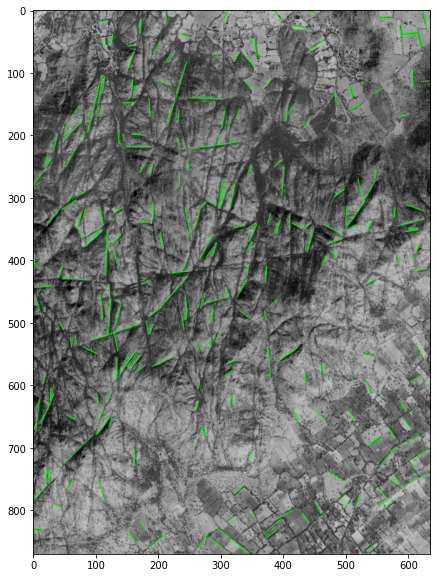

In [ ]:
if fname is None:
  from google.colab import files
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

segments, scores = pyelsed.detect(img)

dbg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

image_shape = img.shape
image_datatype = img.dtype
black_img = np.zeros(image_shape, dtype = image_datatype)
print(image_shape)
print(image_datatype)

#black_img = np.ones(image_shape, dtype = image_datatype)
#black_img = 255*black_img

with open('siwana_half2_elsed.csv', 'w') as f:
      # create the csv writer
      writer = csv.writer(f)
      for s in segments.astype(np.int32):
          cv2.line(dbg, (s[0], s[1]), (s[2], s[3]), (0, 255, 0), 1, cv2.LINE_AA)
          cv2.line(black_img, (s[0], s[1]), (s[2], s[3]), (255, 255, 255), 1, cv2.LINE_AA)
          
          x1 = s[2]-s[0]
          y1=s[3]-s[1]
          x2=0
          y2=10
          angle_theta =  math.acos(np.dot([x1,y1],[x2,y2])/(np.linalg.norm([x1,y1])*np.linalg.norm([x2,y2])))
          angle_degree = math.degrees(angle_theta)
          angle_degree1 = angle_degree%360
        #  angle_degree2 = math.degrees(angle_theta)%180
          theta=math.atan(np.cross([x1,y1],[x2,y2])/np.dot([x1,y1],[x2,y2]))
          degree = math.degrees(theta)%360
        #  degree1 = math.degrees(theta)%180.0
          writer.writerow([s[0],s[1],s[2],s[3],theta,degree,angle_degree,angle_degree1])


plt.imshow(dbg)


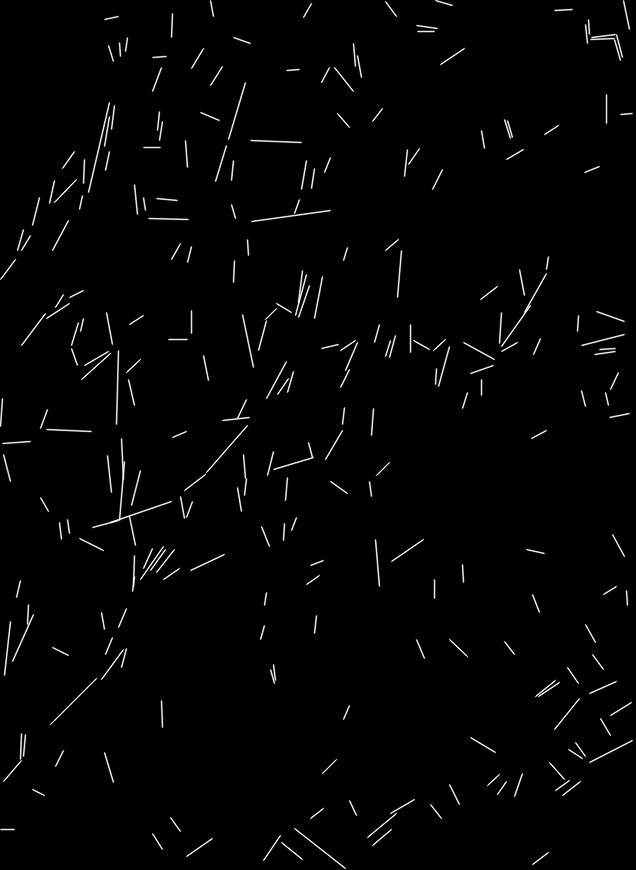

In [ ]:
cv2_imshow(black_img)